In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from datetime import timedelta

In [3]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA

## Data Loading

In [4]:
def parser(s):
    return datetime.strptime(s,"%d-%m-%y")

In [7]:
fish_oil_df=pd.read_csv("Global_fish_oil_quarterly.csv", parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [8]:
fish_oil_df = fish_oil_df.asfreq(pd.infer_freq(fish_oil_df.index))
fish_oil_df.head(100)

date
2021-07-01    6.65
2021-04-01    7.56
2021-01-01    6.37
2020-10-01    5.34
2020-07-01    5.64
              ... 
1997-10-01    3.65
1997-07-01    3.63
1997-04-01    3.63
1997-01-01    4.00
1996-10-01    4.08
Freq: -1QS-OCT, Name: price, Length: 100, dtype: float64

In [9]:
def plot_series(series):
    plt.figure(figsize=(17,8))
    plt.plot(fish_oil_df, color='red')
    plt.title("Global fish oil prices in dollars per metric ton",fontsize=40)
    plt.ylabel("Quarterly prices", fontsize=25)
    for year in range(1990, 2021):
        plt.axvline(datetime(year,1,1), linestyle='--', color='k', alpha=0.2)
    plt.axhline(0, linestyle='--', color='k', alpha=0.3)

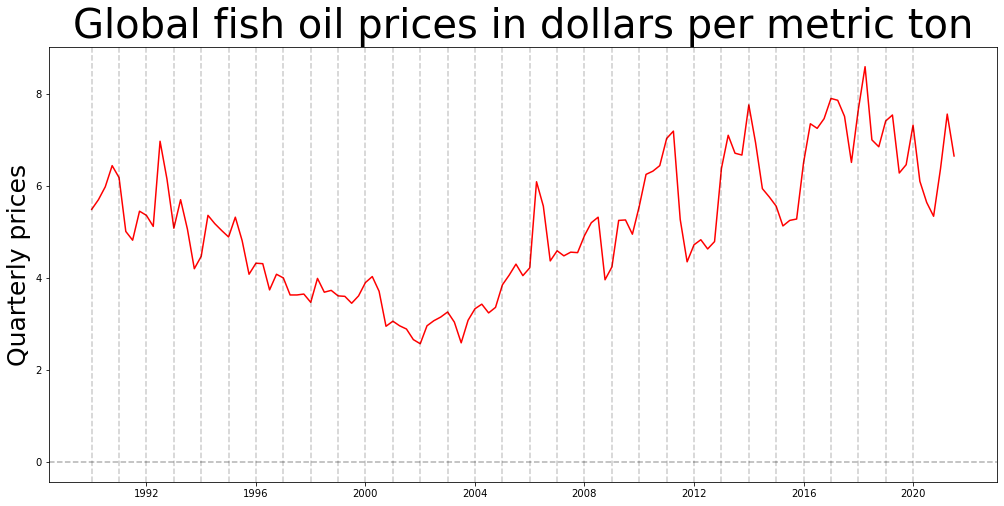

In [10]:
plot_series(fish_oil_df)

In [11]:
#Normalizing the data
avg, std= fish_oil_df.mean(), fish_oil_df.std()
fish_oil_df=fish_oil_df-avg/std

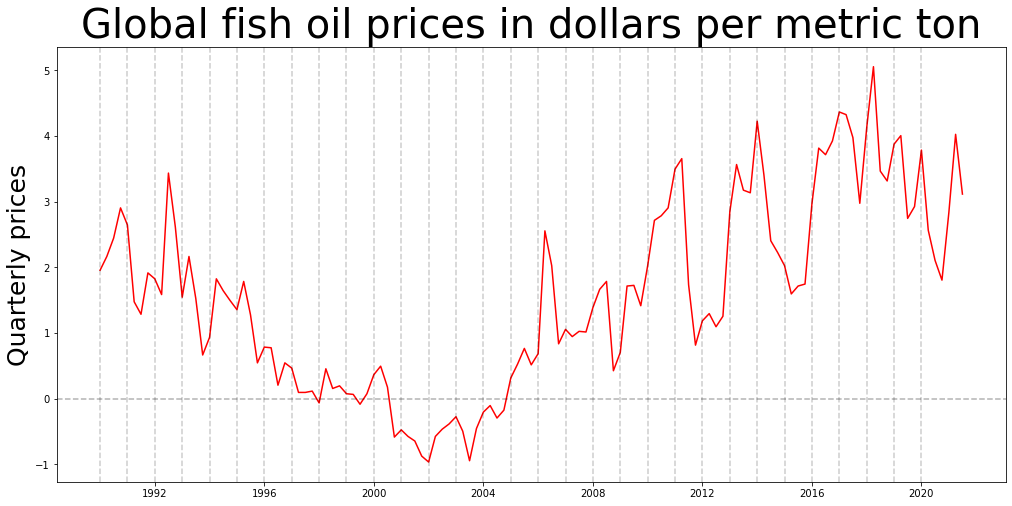

In [12]:
plot_series(fish_oil_df)

### Stationary check

In [13]:
print("Diskey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(fish_oil_df)[1])

Diskey-Fuller test: p=0.607733


### Take First Difference to Remove Trend

In [14]:
fish_oil_df = fish_oil_df.diff().dropna()

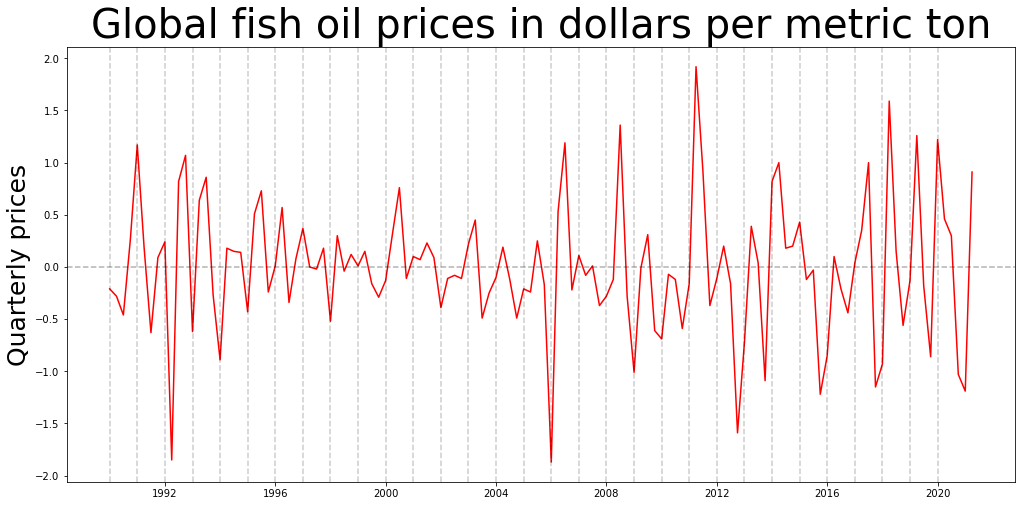

In [15]:
plot_series(fish_oil_df)

### Stationary check

In [16]:
print("Diskey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(fish_oil_df)[1])

Diskey-Fuller test: p=0.000000


### Remove Increasing Volatility

In [17]:
annual_volatility = fish_oil_df.groupby(fish_oil_df.index.year).std()

In [18]:
annual_volatility.head()

date
1990    0.306961
1991    0.739797
1992    1.326374
1993    0.710276
1994    0.523609
Name: price, dtype: float64

In [19]:
fish_oil_annual_vol = fish_oil_df.index.map(lambda d: annual_volatility.loc[d.year])

In [20]:
fish_oil_df = fish_oil_df/fish_oil_annual_vol

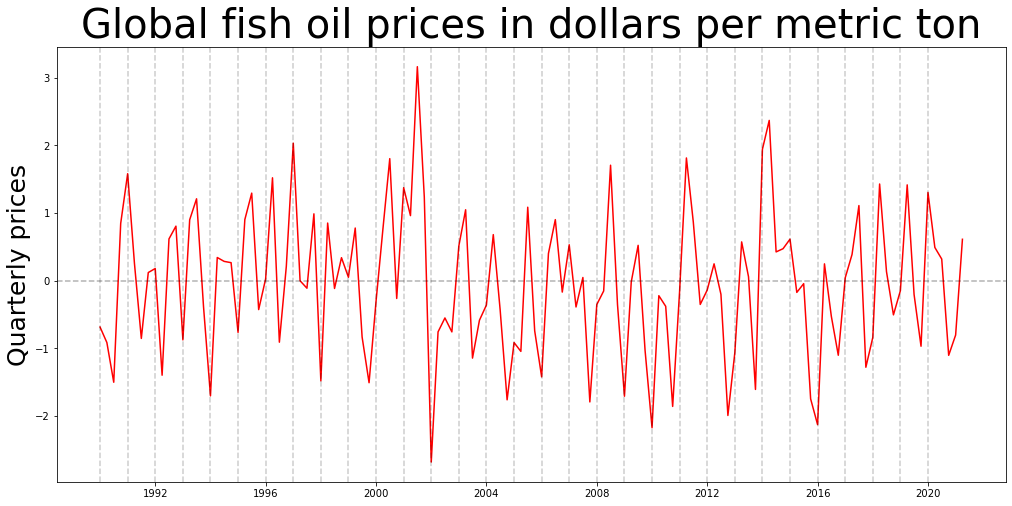

In [21]:
plot_series(fish_oil_df)

### Stationary check

In [22]:
print("Diskey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(fish_oil_df)[1])

Diskey-Fuller test: p=0.000000


### ACF and PACF

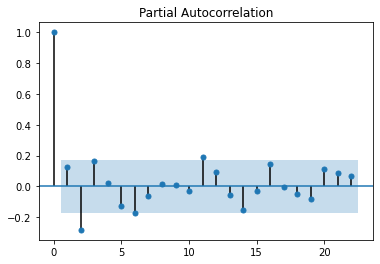

In [23]:
plot_pacf(fish_oil_df)
plt.show()

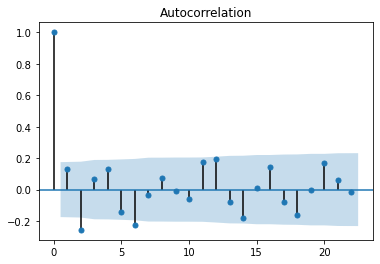

In [24]:
plot_acf(fish_oil_df)
plt.show()

### Get training and testing sets

In [25]:
train_end = datetime(2015,1,1)
test_end = datetime(2021,7,1)

train_data = fish_oil_df[train_end:]
test_data = fish_oil_df[:train_end + timedelta(days=1)]

In [26]:
test_data.head()

date
2021-04-01    0.612826
2021-01-01   -0.801388
2020-10-01   -1.101059
2020-07-01    0.320697
2020-04-01    0.491735
Freq: -1QS-OCT, dtype: float64

In [27]:
#create the model
model = ARMA(fish_oil_df, order=(2,2))

C:\Users\lverm\Anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\lverm\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:587: ValueWarning: A date index has been provided, but it is not monotonic and so wil

In [28]:
model_fit=model.fit()

In [29]:
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  126
Model:                     ARMA(2, 2)   Log Likelihood                -177.492
Method:                       css-mle   S.D. of innovations              0.989
Date:                Wed, 17 Aug 2022   AIC                            366.984
Time:                        16:01:37   BIC                            384.001
Sample:                             0   HQIC                           373.897
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0447      0.088     -0.510      0.610      -0.216       0.127
ar.L1.y       -0.3046      0.253     -1.203      0.229      -0.801       0.192
ar.L2.y       -0.4897      0.202     -2.427      0.0

In [30]:
#get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [31]:
#get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

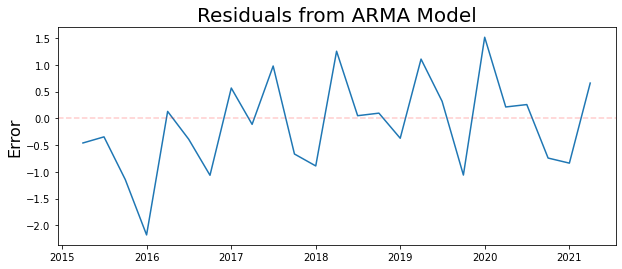

In [32]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from ARMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Quarterly prices')

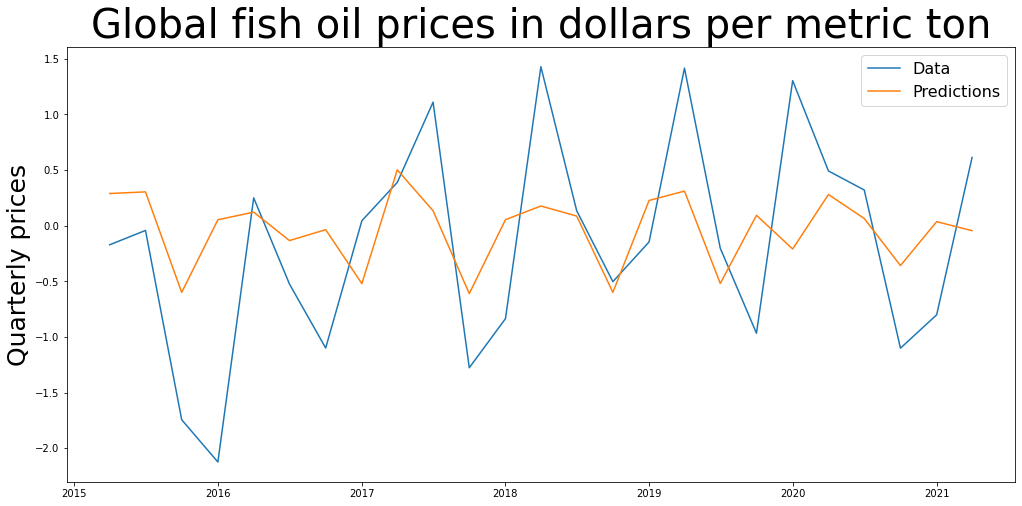

In [33]:
plt.figure(figsize=(17,8))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title("Global fish oil prices in dollars per metric ton",fontsize=40)
plt.ylabel("Quarterly prices", fontsize=25)

In [34]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 0.8592912103327207
